# Import Libraries #

In [167]:
import pandas as pd
import numpy as np
import matplotlib as plt
from scipy import stats


# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans

# Load Data #

In [168]:
cgmdata = "./data/cgm.txt"

# Load raw file
df = pd.read_csv(
    cgmdata,
    sep="|",
    #names=["iPtID", "Period", "DataDtTm", "CGM"],
    names=["patient_id", "period", "date_time", "CGM"],
    skiprows=1
)

# Look at the first few rows
df.head()

,patient_id,period,date_time,CGM
0,1,1. Baseline,11DEC17:23:59:25,172
1,1,1. Baseline,12DEC17:00:04:24,170
2,1,1. Baseline,12DEC17:00:09:24,167
3,1,1. Baseline,12DEC17:00:14:25,163
4,1,1. Baseline,12DEC17:00:19:25,160


# Simple EDA

In [169]:
# OLGA: it is always worthwhile to perform a simple EDA 

print("Dataset shape:", df.shape)
print()
print("Dataset columns:", df.columns)
print()
print("NAs:\n", df.isna().sum())
print()
print("Duplicates:", df.duplicated().sum())
print()
print("Unique patients:", df["patient_id"].nunique())
print()
print("Unique periods:", df["period"].nunique())
print()


Dataset shape: (9032235, 4)

Dataset columns: Index(['patient_id', 'period', 'date_time', 'CGM'], dtype='object')

NAs:
 patient_id    0
period        0
date_time     0
CGM           0
dtype: int64

Duplicates: 0

Unique patients: 168

Unique periods: 2



In [ ]:
# Get basic description for CGM column
# OLGA: it seems like CGM data is within acceptable range (Please confirm that I am correct), so no outliers
df.CGM.describe()

count    9.032235e+06
mean     1.604207e+02
std      6.120771e+01
min      3.900000e+01
25%      1.160000e+02
50%      1.480000e+02
75%      1.930000e+02
max      4.010000e+02
Name: CGM, dtype: float64

In [171]:
# Get dataset description
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9032235 entries, 0 to 9032234
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   patient_id  9032235 non-null  int64 
 1   period      9032235 non-null  object
 2   date_time   9032235 non-null  object
 3   CGM         9032235 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 275.6+ MB


# Convert Timestamp Column to Date Line #

In [172]:
df["date_time"] = pd.to_datetime(
    df["date_time"],
    format="%d%b%y:%H:%M:%S"
)

df.head()

,patient_id,period,date_time,CGM
0,1,1. Baseline,2017-12-11 23:59:25,172
1,1,1. Baseline,2017-12-12 00:04:24,170
2,1,1. Baseline,2017-12-12 00:09:24,167
3,1,1. Baseline,2017-12-12 00:14:25,163
4,1,1. Baseline,2017-12-12 00:19:25,160


In [173]:
# Dates Range
df.date_time.describe()

count                          9032235
mean     2018-05-24 20:09:32.830558720
min                2016-08-04 00:01:34
25%                2018-02-25 16:25:51
50%                2018-05-27 05:28:47
75%                2018-08-21 19:50:11
max                2019-03-25 07:06:50
Name: date_time, dtype: object

# Clean and Pre-Process Data #

In [ ]:
# OLGA: the 2 operations below are not necessary, as we do not have duplicates or NAs.
# When you perform any dataset-altering operations, it is worthwhile to check the shape before and after

print("Dataset shape before dropping duplicates and NAs:", df.shape)
df = df.drop_duplicates()
df = df.dropna()
print("Dataset shape after dropping duplicates and NAs:", df.shape)

print("Periods:", df["period"].unique())

# Only work with baseline periods so there is no bias

# OLGA: it is better to use explicit category selection
#df = df[df['Period'] != '2. Post Randomization']
df = df[df['period'] == '1. Baseline']

# OLGA: We will drop this column, as it is now a single-value column
df.drop(columns=['period'], inplace=True)
print("Dataset shape after dropping periods other than baseline:", df.shape)

Dataset shape before dropping duplicates and NAs: (9032235, 4)
Dataset shape after dropping duplicates and NAs: (9032235, 4)
Periods: ['1. Baseline' '2. Post Randomization']
Dataset shape after dropping periods other than baseline: (602103, 3)


# Seperating by Day #
Testing with one Patient

In [175]:
# OLGA: IMPORTANT! We need to know the start and end dates for the patient data. Most of the patients have data recorded for 4 weeks only.
patient_id = 10
star_date = pd.to_datetime('4/3/2018', dayfirst=True)
timespan_days = 90

In [176]:
def get_patient_data_dates(df, patient_id):
    """
    Get the start and end dates for a given patient's data.
    """
    patient_df = df[df['patient_id'] == patient_id]
    
    if patient_df.empty:
        print(f"No data found for patient {patient_id}")
        return None, None
    
    start_date = patient_df['date_time'].min().date()
    end_date = patient_df['date_time'].max().date()
    range = end_date - start_date
    
      
    return start_date, end_date, range.days

In [177]:
def get_patients_dates_range(df):
    """
    Get the start and end dates for all patients' data.
    """
    patient_ranges = (
    df.groupby('patient_id')['date_time']
    .agg(start_date='min', end_date='max')
    .reset_index()
    )
    patient_ranges['range'] = patient_ranges['end_date'].dt.date- patient_ranges['start_date'].dt.date
    patient_ranges['range'] = patient_ranges['range'].apply(lambda x: x.days)
    
    return patient_ranges

In [178]:
get_patients_dates_range(df)

,patient_id,start_date,end_date,range
0,1,2017-12-11 23:59:25,2017-12-25 23:59:09,14
1,2,2018-01-08 00:02:54,2018-01-20 23:57:30,12
2,3,2017-12-28 00:01:21,2018-01-10 23:58:24,13
3,4,2017-08-13 00:00:09,2017-08-26 23:59:35,13
4,5,2018-01-29 23:56:41,2018-02-12 23:56:20,14
...,...,...,...,...
163,167,2018-05-17 00:01:30,2018-05-29 23:56:01,12
164,168,2018-04-29 00:04:30,2018-05-11 23:59:02,12
165,169,2018-07-02 00:02:08,2018-07-14 23:56:37,12
166,170,2018-04-14 00:01:00,2018-04-27 13:00:00,13


In [179]:
print(f"Patient {patient_id} data dates range:")
start_date, end_date, range_days  = get_patient_data_dates(df, patient_id)
if start_date and end_date:
    print(f"Start date: {start_date}, End date: {end_date}, Range: {range_days} days")

Patient 10 data dates range:
Start date: 2018-04-03, End date: 2018-04-17, Range: 14 days


In [180]:
# Function to plot CGM data for a given patient
def plot_patient_cgm(df, patient_id, start_date, timespan_days=30):
    """
    Plot CGM data for a given patient over a specified time period.
    
    Parameters:
    df (DataFrame): The DataFrame containing CGM data.
    patient_id (int): The ID of the patient to plot.
    start_date (datetime): The start date for the plot.
    timespan_days (int): The number of days to include in the plot.
    """
    patient_df = df[df['patient_id'] == patient_id]
    patient_df = patient_df.loc[
        (patient_df['date_time'] >= start_date) & 
        (patient_df['date_time'] < start_date + pd.Timedelta(days=timespan_days)), 
        ['date_time', 'CGM']
    ]
    

    if  patient_df.empty:
        print(f"No data available for Patient {patient_id} in the specified time range.")
    else:
        patient_df.set_index('date_time')['CGM'].plot(title=f'CGM Data for Patient {patient_id}', xlabel='Date', ylabel='CGM Value')
        

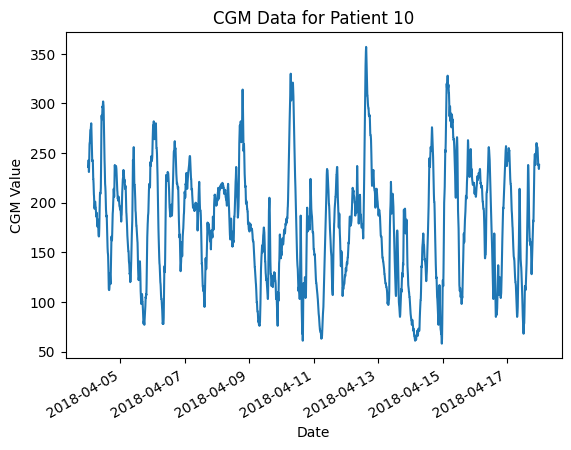

In [181]:
plot_patient_cgm(df, patient_id, star_date, timespan_days)

In [ ]:
# OLGA: Let's convert this into a function to make it reusable

# Helper functions
def pct_high(series):
        return (series > 180).mean() * 100

def pct_low(series):
    return (series < 70).mean() * 100

def range(series):
    return np.max(series) - np.min(series)

def calculate_patient_cgm_stats(df, patient_id, start_date, timespan_days=30):
    """
    Calculate basic statistics for a given patient's CGM data.
    
    Parameters:
    df (DataFrame): The DataFrame containing CGM data.
    patient_id (int): The ID of the patient to analyze.
    
    Returns:
    Series: A Series containing the mean, median, and standard deviation of the patient's CGM data.
    """
    patient_df = df[df['patient_id'] == patient_id]
    patient_df = patient_df.loc[
        (patient_df['date_time'] >= start_date) & 
        (patient_df['date_time'] < start_date + pd.Timedelta(days=timespan_days)), 
        ['date_time', 'CGM']
    ]
    
    if  patient_df.empty:
        print(f"No data available for Patient {patient_id} in the specified time range.")
        return
    
    print(f"Dataset shape for patient {patient_id}: {patient_df.shape}\n")
    print(patient_df.date_time.nunique(), "unique date_time")
    assert patient_df.date_time.nunique() == patient_df.shape[0], "There are duplicate dates for the patient"


   # OLGA: IMPORTANT!!! We have to group by date, not by date_time
    patient_df['date'] = patient_df['date_time'].dt.date
    print(patient_df.date.nunique(), "days")

    statistics = ['mean', 'std', 'min', 'max', range, 'median', stats.iqr, stats.skew, stats.kurtosis, pct_high, pct_low]
    statistics_cols = ['mean', 'std', 'min', 'max', 'range', 'median', 'iqr', 'skew', 'kurtosis', 'pct_high', 'pct_low']

    patient_stats = patient_df.groupby('date').agg({'CGM' : statistics}).reset_index()
    patient_stats.columns = ['date'] + statistics_cols

    # Round statistics to 2 decimal places
    patient_stats[statistics_cols] = patient_stats[statistics_cols].round(2)

    # Get time of peak and low CGM for each day
    idx_peak = patient_df.groupby('date')['CGM'].idxmax()
    idx_low = patient_df.groupby('date')['CGM'].idxmin()
    time_of_peak = patient_df.loc[idx_peak, ['date', 'date_time']]
    time_of_peak['time_of_peak'] = time_of_peak['date_time'].dt.time
    time_of_low = patient_df.loc[idx_low, ['date', 'date_time']]
    time_of_low['time_of_low'] = time_of_low['date_time'].dt.time


    patient_stats = patient_stats.merge(time_of_peak[['date', 'time_of_peak']], on='date')
    patient_stats = patient_stats.merge(time_of_low[['date', 'time_of_low']], on='date')
    
    return patient_stats



In [187]:
patient_stats = calculate_patient_cgm_stats(df, patient_id, star_date, timespan_days)
patient_stats

Dataset shape for patient 10: (4008, 2)

4008 unique date_time
15 days


,date,mean,std,min,max,range,median,iqr,skew,kurtosis,pct_high,pct_low,time_of_peak,time_of_low
0,2018-04-03,236.00,NaN,236,236,0,236.0,0.00,NaN,NaN,100.00,0.00,23:58:52,23:58:52
1,2018-04-04,208.88,45.43,112,302,190,206.0,54.00,0.00,-0.34,76.39,0.00,11:03:51,15:24:35
2,2018-04-05,170.15,51.02,77,261,184,175.5,91.00,-0.14,-1.19,47.22,0.00,23:59:26,17:44:28
3,2018-04-06,193.81,54.56,78,282,204,198.0,77.00,-0.36,-0.73,63.54,0.00,00:49:27,07:29:25
4,2018-04-07,185.37,35.43,95,247,152,194.0,40.00,-0.65,-0.10,59.38,0.00,03:39:20,14:39:19
5,2018-04-08,211.85,33.28,156,314,158,210.0,27.25,0.81,0.55,83.33,0.00,19:04:12,11:14:16
6,2018-04-09,133.44,31.27,76,205,129,128.0,48.25,0.02,-0.80,3.47,0.00,14:59:10,07:29:11
7,2018-04-10,183.93,65.18,61,330,269,176.0,68.00,0.63,-0.21,42.71,1.39,06:54:06,15:49:04
8,2018-04-11,146.38,49.44,63,236,173,142.0,75.50,0.16,-1.02,28.14,4.94,17:23:59,05:39:02
9,2018-04-12,216.09,50.93,131,357,226,205.5,46.00,0.93,0.33,78.12,0.00,15:03:54,00:13:57


In [188]:
patient_stats.to_csv(f"./output/patient_{patient_id}_stats.csv", index=False)

In [ ]:
# OLGA: TODO NEXT:
# 1. Add LLM, feed it with patient_stats and ask it to generate a report. Start with Ollama, as you have it installed already. Look at the week 2 ai-academy materials.
# 2. Generate csv files with patient stats for all patients
# 3. Ask LLM to generate a report for all patients

In [184]:
# summaries = []
# glucose_readings = []
# grouped = df10.groupby("DataDtTm")
# day = ''

# for date, group in grouped:
#     glucose = group["CGM"]
    
#     glucose_readings.append(glucose)


#     mean = round(glucose.mean(),2)
#     std = round(glucose.std(), 2)
#     pct_high = round((glucose > 180).mean() * 100, 2)
#     pct_low = round((glucose < 70).mean() * 100, 2)
#     max_value = glucose.max()
#     min_value = glucose.min()
#     time_of_peak = group.loc[glucose.idxmax(), "DataDtTm"].time()
#     time_of_lowest = group.loc[glucose.idxmin(), "DataDtTm"].time()

    


    
#     summary = {
#         "Date": str(date),
#         "cgm_level": ,
#         "StdDev": std,
#         "PercentAbove180": pct_high,
#         "PercentBelow70": pct_low,
#         "Max": max_value,
#         "Min": min_value,
#         "TimeOfPeak": str(time_of_peak)
#     }


#     summaries.append(summary)
    
# for s in summaries:
#     print(s)

In [185]:
# sums = {}
# counts = {}
# mean_values = []


# for row in summaries:
#     for key, value in row.items():
#         if isinstance(value, (int, float)) and value is not None:
#             if key not in sums:
#                 sums[key] = 0
#                 counts[key] = 0
#             sums[key] += value
#             counts[key] += 1
#             if key == "Mean":
#                 mean_values.append(value)

# averages = {key: sums[key] / counts[key] for key in sums}


# mean_of_means = averages["Mean"]
# cgm_variability = math.sqrt(sum((x - mean_of_means) ** 2 for x in mean_values) / len(mean_values))


# averages["CGM Variability"] = cgm_variability
# averages.pop("StdDev")

# print("Average summary:")
# for key, avg in averages.items():
#     print(f"{key}: {avg:.2f}")

NameError: name 'summaries' is not defined